In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pdfplumber
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
## load ChatQA-1.5 tokenizer and model
model_id = "C:/Users/jywun/Desktop/NYCU/模組/QA_ARAG/Llama3-ChatQA-1.5-8B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16).to(device)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.54s/it]


In [10]:
embedding_model_path = "BAAI/bge-large-en-v1.5"
reference_doc_path = "WWF_Plastic_Policy_Summit_2024_Key_Takeaways_.pdf"
question_path = 'output_complex.txt'
messages = [
    {"role": "user", "content": ""}
]
terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]
low_confidence_first = []
low_confidence_second = []
first_answer = []
second_answer = [] 
max_length = 512

In [6]:
def get_reference_document(path, chunk_size = 500, chunk_overlap = 100):
    with pdfplumber.open(path) as pdf: 
        content = ''
        for i in range(len(pdf.pages)):
            page = pdf.pages[i]
            page_content = '\n'.join(page.extract_text().split('\n')[:-1])
            content = content + page_content
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        text_chunks = text_splitter.split_text(content)
        docs = [Document(page_content=t) for t in text_chunks]

    return docs

def get_question_from_txt(path):
    with open(path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    question = []
    for line in lines:
        text_without_numbers_and_periods = re.sub(r'[\d.]+', '', line)
        cleaned_question = text_without_numbers_and_periods.replace('\n', '')
        question.append(cleaned_question)
        
    return question

def replace_message_content(question):
    messages = [
    {"role": "user", "content": ""}
    ]
    messages[0]['content'] = question.strip()

    return messages

def retrival(vector_store, search_kwargs, question):
    retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={'k': search_kwargs})
    doc = retriever.invoke(question)

    result = []
    for part in doc:
            if part.page_content not in result:
                result.append(part.page_content)

    return result

def get_formatted_input(messages, context):
    system = "System: This is a chat between a user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions based on the context. The assistant should also indicate when the answer cannot be found in the context."
    instruction = "Please give a full and complete answer for the question."


            ## only apply this instruction for the first user turn
    messages[0]['content'] = instruction + " Question: " + messages[0]['content']


    conversation = '\n\n'.join(["User: " + item["content"] if item["role"] == "user" else "Assistant: " + item["content"] for item in messages]) + "\nAssistant:"
    formatted_input = system + "\n\n" + "retrival 1:\n" + context[0] + "\n\n" + conversation
    
    return formatted_input 

def get_formatted_input_cloze(messages, context, generated_tokens):
    system = "System: This is an artificial intelligence assistant that can complete sentences with uncertain parts removed due to low confidence. The assistant provides contextually accurate answers to the user's questions."
    instruction = "Please modify answer based on context and user questions."
    generated_tokens = generated_tokens[1:-1]
    cloze = tokenizer.decode(generated_tokens)
    messages[0]['content'] = instruction + " Question: " + messages[0]['content']

    conversation = '\n\n'.join(["User: " + item["content"] if item["role"] == "user" else "Assistant: " + item["content"] for item in messages]) + " Answer:" + cloze + "\nAssistant:"
    formatted_input = system + "\n\n" + "retrival 1:\n" + context[0]  + "\n" "retrival 2:\n" + context[-1] + "\n\n" + conversation
    
    return formatted_input

def find_below_threshold_indices(generated_probabilities, threshold):
    below_threshold_indices = []
    for i, val in enumerate(generated_probabilities):
        if val < threshold:
            below_threshold_indices.append(i)

    return below_threshold_indices

def remove_below_threshold_tokens(generated_tokens, generated_probabilities, threshold, turn=0):
    below_threshold_indices = find_below_threshold_indices(generated_probabilities, threshold)
    if turn == 1:
        low_confidence_first.append(len(below_threshold_indices))
        for i in reversed(below_threshold_indices):
            generated_tokens.pop(i)
    else:
        low_confidence_second.append(len(below_threshold_indices))
        

    return generated_tokens

def remove_bos_eos(generated_text):
    result = generated_text.replace("<|begin_of_text|> ", "")
    result = result.replace("<|end_of_text|>", "")

    return result

def first_retrieval_answer(vector_store, question, question_num=0):
    retrival_doc = retrival(vector_store, 1, question[question_num])
    formatted_input = get_formatted_input(messages, retrival_doc)
    tokenized_prompt = tokenizer(tokenizer.bos_token + formatted_input, return_tensors="pt").to(model.device)
    tokenized_prompt_recursive = tokenized_prompt.input_ids
    generated_tokens = []
    generated_probabilities = []
    print("start first generating\n")
    model.eval()
    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(tokenized_prompt_recursive)
            logits = outputs.logits

            temperature = 0.7  
            logits = logits / temperature
            probabilities = F.softmax(logits[:, -1, :], dim=-1).squeeze()

            # next_token = torch.argmax(probabilities[:, -1, :], dim=-1).unsqueeze(-1)
            next_token = torch.multinomial(probabilities, num_samples=1)
            print(tokenizer.decode(next_token.item()), end="")

            generated_tokens.append(next_token.item())
            generated_probabilities.append(probabilities.squeeze()[next_token])
            # 将生成的标记加入到输入中以生成下一个标记
            tokenized_prompt_recursive = torch.cat([tokenized_prompt_recursive, next_token.unsqueeze(0)], dim=1)
            if next_token.item() in terminators:
                break
    generated_text = tokenizer.decode(generated_tokens)
    first = remove_bos_eos(generated_text)
    # print(first)
    first_answer.append(first)
    
    return generated_tokens, generated_probabilities

def second_retrieval_answer(vector_store, generated_tokens, question, question_num=0):
    retrival_doc = retrival(vector_store, 2, question[question_num])
    formatted_input = get_formatted_input_cloze(messages, retrival_doc, generated_tokens)
    tokenized_prompt = tokenizer(tokenizer.bos_token + formatted_input, return_tensors="pt").to(model.device)
    tokenized_prompt_recursive = tokenized_prompt.input_ids
    generated_tokens = []
    generated_probabilities = []
    print("start second generating\n")
    model.eval()
    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(tokenized_prompt_recursive)
            logits = outputs.logits

            temperature = 0.7  
            logits = logits / temperature
            probabilities = F.softmax(logits[:, -1, :], dim=-1).squeeze()
            
            next_token = torch.argmax(probabilities).unsqueeze(-1)
            # next_token = torch.multinomial(probabilities, num_samples=1)
            # print(tokenizer.decode(next_token.item()))

            generated_tokens.append(next_token.item())
            generated_probabilities.append(probabilities.squeeze()[next_token])
            # 将生成的标记加入到输入中以生成下一个标记
            tokenized_prompt_recursive = torch.cat([tokenized_prompt_recursive, next_token.unsqueeze(0)], dim=1)
            if next_token.item() in terminators:
                break
    generated_text = tokenizer.decode(generated_tokens)
    second = remove_bos_eos(generated_text)
    # print(second)
    second_answer.append(second)
    
    return generated_tokens, generated_probabilities

In [14]:
docs = get_reference_document(reference_doc_path, 800, 200)
question = get_question_from_txt(question_path)    

embeddings = HuggingFaceEmbeddings(model_name=embedding_model_path)
vector_store = Chroma.from_documents(docs, embeddings)

HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': 'C:/Users/jywun/Desktop/NYCU/模組/QA_ARAG/bge-large-en-v1.5'. Use `repo_type` argument if needed.

In [5]:
for i in tqdm(range(1, len(question)+1), desc="Processing questions"):
    print(i,":")
    messages = replace_message_content(question[i-1])
    generated_tokens_1, generated_probabilities_1 = first_retrieval_answer(vector_store, question, i-1)
    cloze = remove_below_threshold_tokens(generated_tokens_1, generated_probabilities_1, 0.5, 1)

    messages = replace_message_content(question[i-1])
    generated_tokens_2, generated_probabilities_2 = second_retrieval_answer(vector_store, generated_tokens_1, question, i-1)

    remove_below_threshold_tokens(generated_tokens_2, generated_probabilities_2, 0.5)

Processing questions:   0%|          | 0/20 [00:00<?, ?it/s]

1 :
start first generating

<|begin_of_text|> To answer your question, I would need more context. Would you like a broad overview of the challenges and solutions related to plastic pollution, or a more specific discussion of a particular aspect of sector collaboration? Please provide additional details about your research needs so I can provide a more focused and comprehensive response.<|end_of_text|>start second generating



Processing questions:   5%|▌         | 1/20 [00:03<01:10,  3.72s/it]

2 :
start first generating

<|begin_of_text|> By advocating for a just and urgent transition to a circular economy, and conducting research that informs and supports those efforts, NGOs and activists can push for systemic change to effectively end plastic pollution.<|end_of_text|>start second generating



Processing questions:  10%|█         | 2/20 [00:10<01:38,  5.46s/it]

3 :
start first generating

<|begin_of_text|> The collaboration of various sectors in addressing plastic pollution, as opposed to working independently, is crucial for a more effective and comprehensive solution to this environmental issue.<|end_of_text|>start second generating



Processing questions:  15%|█▌        | 3/20 [00:13<01:13,  4.31s/it]

4 :
start first generating

<|begin_of_text|> A whole-of-society approach that includes collaboration among businesses, NGOs, activists, academia, state and local governments, and the federal government is necessary to effectively mitigate plastic pollution and create a future where plastic no longer harms people or the planet. This strategy would encompass a diverse range of stakeholders, each bringing unique perspectives and expertise to the table.<|end_of_text|>start second generating



Processing questions:  20%|██        | 4/20 [00:23<01:44,  6.54s/it]

5 :
start first generating

<|begin_of_text|> NGOs and activists can strategically collaborate with public and private entities to foster innovation and develop effective solutions aimed at addressing the issue of plastic pollution by advocating for and prioritizing a just and urgent transition to a circular economy. This transition requires collaboration between all sectors to amplify, replicate, and scale solutions.<|end_of_text|>start second generating



Processing questions:  25%|██▌       | 5/20 [00:28<01:33,  6.23s/it]

6 :
start first generating

<|begin_of_text|> Companies can effectively align their strategic initiatives with global efforts to address environmental issues related to plastic pollution in a variety of ways, including advocating for regulation, engaging in corporate social responsibility programs, promoting sustainability within their supply chains, and working with governments and other stakeholders to develop and implement solutions.<|end_of_text|>start second generating



Processing questions:  30%|███       | 6/20 [00:34<01:22,  5.90s/it]

7 :
start first generating

<|begin_of_text|> Industry collaboration can bring valuable expertise, resources, and networks to the table.<|end_of_text|>start second generating



Processing questions:  35%|███▌      | 7/20 [00:39<01:12,  5.54s/it]

8 :
start first generating

<|begin_of_text|> Stakeholders can engage with organizations like WWF, ABA, and The Recycling Partnership in various ways to achieve this goal. For instance, they can attend and participate in conferences and events organized by these organizations to network with like-minded individuals and learn about the latest developments and best practices in the field. Additionally, stakeholders can leverage their expertise and resources to contribute to research and advocacy efforts, helping to build a stronger case for action and increase the likelihood of securing funding and support for effective solutions. Finally, stakeholders can work collaboratively with these organizations to develop and implement targeted campaigns and initiatives that address specific aspects of the plastic pollution challenge, such as reducing single-use plastic consumption or improving waste management infrastructure. By leveraging their resources and collaborating with organizations that

Processing questions:  40%|████      | 8/20 [00:49<01:26,  7.18s/it]

9 :
start first generating

<|begin_of_text|> All stakeholders must actively contribute to both voluntary and mandatory measures to eliminate plastic pollution. Local, state, and federal governments, as well as civil society, the private sector, and individuals, have a role to play in this transition.<|end_of_text|>start second generating



Processing questions:  45%|████▌     | 9/20 [00:55<01:14,  6.80s/it]

10 :
start first generating

<|begin_of_text|> To ensure effective implementation of strategic actions to address plastic pollution, it is crucial to harmonize policy frameworks across all levels of government. This can be achieved through a collaborative and coordinated approach that involves federal, state, and local governments. The following steps can be taken to achieve this goal:
1. Review existing federal authorities: Analyze existing federal laws and regulations related to plastic pollution and identify any gaps or obsolete provisions that need to be addressed.
2. Establish federal plastic pollution priorities: Set clear priorities and goals for addressing plastic pollution at the federal level, including specific targets and timelines for reducing plastic waste and promoting sustainable alternatives.
3. Collaborate with state and local governments: Engage with state and local governments to align policy frameworks and ensure that efforts at all levels of government are complem

Processing questions:  50%|█████     | 10/20 [03:58<10:11, 61.11s/it]

11 :
start first generating

<|begin_of_text|> One effective way stakeholders can promote and support the implementation of robust policies aimed at plastic pollution is by using existing authorities and federal agencies to drive progress on domestic plastic waste as well as negotiate an ambitious global plastic treaty.<|end_of_text|>start second generating



Processing questions:  55%|█████▌    | 11/20 [04:12<07:00, 46.69s/it]

12 :
start first generating

<|begin_of_text|> Companies can strategically enhance their appeal to investors and expand into untapped markets for sustainable products by advocating for regulation to address plastic pollution. They can also develop harmonized criteria to identify harmful chemical substances, materials, and chemicals in plastic products and promote transparency in product disclosure by ensuring that all companies across the value chain adhere to the same standards. Furthermore, companies can focus on developing alternatives to single-use plastic products and incentivizing their use through pricing and public awareness campaigns. This will not only increase their appeal to investors but also expand their market share by tapping into new, untapped markets for sustainable products.<|end_of_text|>start second generating



Processing questions:  60%|██████    | 12/20 [04:41<05:31, 41.43s/it]

13 :
start first generating

<|begin_of_text|> To effectively collaborate in addressing plastic pollution, stakeholders from various sectors can work together in the following ways: share best practices, promote collaboration among stakeholders, encourage inter-agency collaboration, encourage the sharing of data and knowledge, and encourage the sharing of resources. These collaborative efforts will enhance the impact and expand the reach of innovative strategies aimed at addressing the issue of plastic pollution.<|end_of_text|>start second generating



Processing questions:  65%|██████▌   | 13/20 [04:54<03:49, 32.74s/it]

14 :
start first generating

<|begin_of_text|> Congress can advance legislation that encourages reduction, fosters reuse, improves recycling, and protects communities from harm. State and local governments can implement policy frameworks that could later be scaled up.<|end_of_text|>start second generating



Processing questions:  70%|███████   | 14/20 [05:16<02:57, 29.51s/it]

15 :
start first generating

<|begin_of_text|> In what ways can stakeholders strategically advocate for and implement a combination of voluntary and mandatory initiatives to effectively address the issue of plastic pollution?<|end_of_text|>start second generating



Processing questions:  75%|███████▌  | 15/20 [05:28<02:01, 24.27s/it]

16 :
start first generating

<|begin_of_text|> Stakeholders can implement specific strategies and actions to effectively engage all parties in the collective effort to combat plastic pollution.<|end_of_text|>start second generating



Processing questions:  80%|████████  | 16/20 [05:45<01:28, 22.13s/it]

17 :
start first generating

<|begin_of_text|> Federal agencies can strategically partner with state and local governments by sharing information, resources, and expertise, promoting collaboration, advocating for policies and funding, and supporting pilot projects.<|end_of_text|>start second generating



Processing questions:  85%|████████▌ | 17/20 [05:52<00:52, 17.52s/it]

18 :
start first generating

<|begin_of_text|> Stakeholders can strategically engage in the legislative process at the congressional level by advocating for legislation that supports plastic reduction, promotes reuse, enhances recycling practices, and safeguards communities from potential harm. This can be done through meetings with lawmakers, public testimony, and other forms of outreach to ensure that the voices of those affected by plastic pollution are heard. Additionally, stakeholders can work with lawmakers to draft legislation that addresses the root causes of plastic pollution and creates solutions that are both effective and sustainable.<|end_of_text|>start second generating



Processing questions:  90%|█████████ | 18/20 [06:06<00:32, 16.29s/it]

19 :
start first generating

<|begin_of_text|> To strengthen strategic partnerships and cooperative ventures between various industries, it is important to establish clear goals and objectives that align with the overall objective of eradicating plastic pollution. An effective communication strategy that promotes transparency and fosters trust is also crucial. Additionally, the use of cutting-edge technology can help streamline operations and ensure that goals are met in a timely and efficient manner.<|end_of_text|>start second generating



Processing questions:  95%|█████████▌| 19/20 [06:28<00:18, 18.01s/it]

20 :
start first generating

<|begin_of_text|> Companies can build resilience against environmental risks and become more appealing to investors, as well as tap new markets for reusable and lower-waste products. The private sector should also engage in public-private partnerships, which can effectively drive innovation and solutions. Redesign will be a key focus as we move toward a circular economy, where materials are reused and repurposed.<|end_of_text|>start second generating



Processing questions: 100%|██████████| 20/20 [06:58<00:00, 20.95s/it]


In [6]:
print(first_answer[0])
print(second_answer[0])
print(low_confidence_first)
print(low_confidence_second)

To answer your question, I would need more context. Would you like a broad overview of the challenges and solutions related to plastic pollution, or a more specific discussion of a particular aspect of sector collaboration? Please provide additional details about your research needs so I can provide a more focused and comprehensive response.
Sorry. I cannot find the answer based on the context and user questions.
[23, 14, 3, 18, 10, 13, 5, 32, 16, 57, 8, 39, 26, 5, 2, 2, 14, 17, 26, 13]
[1, 15, 1, 3, 2, 1, 13, 1, 11, 3, 1, 6, 1, 5, 6, 2, 2, 1, 2, 5]


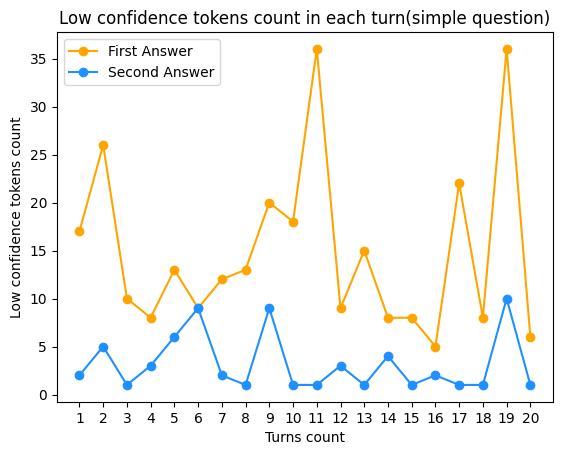

In [19]:
low_confidence_first = [17, 26, 10, 8, 13, 9, 12, 13, 20, 18, 36, 9, 15, 8, 8, 5, 22, 8, 36, 6]
low_confidence_second = [2, 5, 1, 3, 6, 9, 2, 1, 9, 1, 1, 3, 1, 4, 1, 2, 1, 1, 10, 1]
plt.figure()
x = [i+1 for i in range(0, len(low_confidence_first))]
plt.plot(x,low_confidence_first, label='First Answer', color='orange', marker='o')
plt.plot(x,low_confidence_second, label='Second Answer', color='dodgerblue', marker='o')
plt.title('Low confidence tokens count in each turn(simple question)')
plt.xticks(x)
plt.xlabel('Turns count')
plt.ylabel('Low confidence tokens count')
plt.legend()
plt.show()

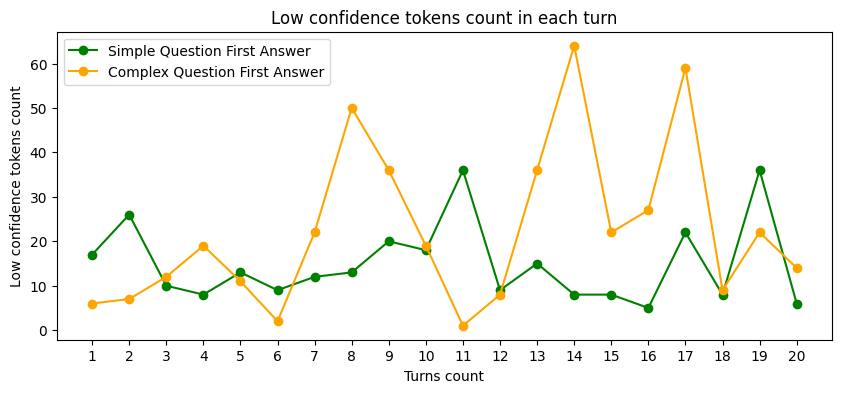

In [23]:
simple_Q = [17, 26, 10, 8, 13, 9, 12, 13, 20, 18, 36, 9, 15, 8, 8, 5, 22, 8, 36, 6]
simple_Q2 = [2, 5, 1, 3, 6, 9, 2, 1, 9, 1, 1, 3, 1, 4, 1, 2, 1, 1, 10, 1]
complex_Q = [6, 7, 12, 19, 11, 2, 22, 50, 36, 19, 1, 8, 36, 64, 22, 27, 59, 9, 22, 14]
complex_Q2 = [3, 12, 2, 5, 1, 1, 6, 5, 2, 4, 1, 10, 5, 5, 2, 4, 4, 4, 3, 5]
plt.figure(figsize=(10, 4))
x = [i+1 for i in range(0, len(simple_Q))]
plt.plot(x,simple_Q, label='Simple Question First Answer', color='green', marker='o')
plt.plot(x,complex_Q, label='Complex Question First Answer', color='orange', marker='o')
plt.title('Low confidence tokens count in each turn')
plt.xticks(x)
plt.xlabel('Turns count')
plt.ylabel('Low confidence tokens count')
plt.legend()
plt.show()


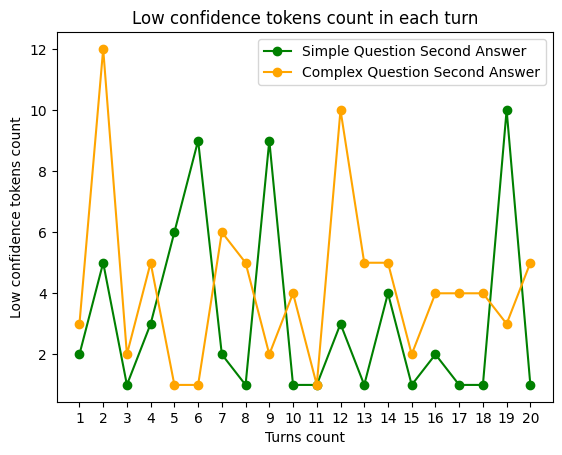

In [11]:
plt.figure()
x = [i+1 for i in range(0, len(simple_Q2))]
plt.plot(x,simple_Q2, label='Simple Question Second Answer', color='green', marker='o')
plt.plot(x,complex_Q2, label='Complex Question Second Answer', color='orange', marker='o')
plt.title('Low confidence tokens count in each turn')
plt.xticks(x)
plt.xlabel('Turns count')
plt.ylabel('Low confidence tokens count')
plt.legend()
plt.show()